# Week 13: Chapter 12 - Introducing deep learning for time series forecasting

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mpl
import pandas as pd
import datetime

from sklearn.preprocessing import MinMaxScaler

In [2]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
  "font.size": 16,
  "grid.alpha": 0.25})


Prerequisite concepts:
- Activation functions
- Loss functions
- Batches
- Layers
- Epochs

## 12.1 When to use deep learning for time series forecasting

- The number of data points is too large to use for finding
  the optimal order in SARIMAX or VAR models and takes so much computational time
- There are more than one seasonality in a single time series
- There is a nonlinear relationship between features

## 12.2 Exploring the different types of deep learning models

**Single-step model**    
The single-step model outpus a single value representing the prediction for the  
next timestep. The input can be of any length, but the output remains a single  
prediction for the next timestep.


**Multi-step model**  
In a multi-step model, the output of the model is a sequence of values   
representing predictions for many timesteps into the future. For example,  
if the model predicts the next 6 hours, 24 hours, or 12 months, it is a   multi-step  model

**Multi-output model**   
A multi-output model generates predictions for more than one target. For   
example, if we forecast the temperature and wind speed, it is a multi-output model.

## 12.3 Getting ready to apply deep learning for forecasting

There are a cleaning for data preparation, but we skip that process and put to  
another notebook. The dataset that we used in here have been preprocessed.
See `./datasets/Metro_Interstate_Traffic_Volume.csv` for the original dataset.

### Performing data exploration

In [22]:
filename = "./datasets/metro_interstate_traffic_volume_preprocessed.csv"
df_traffic = pd.read_csv(filename, parse_dates=["date_time"])
display(df_traffic.head())

len(df_traffic)


,date_time,temp,rain_1h,snow_1h,clouds_all,traffic_volume
0,2016-09-29 17:00:00,291.75,0.0,0,0,5551.0
1,2016-09-29 18:00:00,290.36,0.0,0,0,4132.0
2,2016-09-29 19:00:00,287.86,0.0,0,0,3435.0
3,2016-09-29 20:00:00,285.91,0.0,0,0,2765.0
4,2016-09-29 21:00:00,284.31,0.0,0,0,2443.0


17551

**Table 12.1 The variables in the metro interstate traffic volume**    
<table>
  <tr>
    <td> <b>Feature
    <td> <b>Description
  <tr> 
    <td> <code>date_time
    <td> Date and time of the data, recorded in the CST time zone. The format
         is YYYY-MM-DD HH:MM:SS
  <tr>
    <td> <code>temp
    <td> Average temperature recorded in the hour, expressed in Kelvin.
  <tr>
    <td> <code>rain_1h
    <td> Amount of rain that occurred in the hour, expressed in milimetters.
  <tr>
    <td> <code>snow_1h
    <td> Amount of snow that occurred in the hour, expressed in milimetters.
  <tr>
    <td> <code>clouds_all
    <td> Percentage of cloud cover during the hour.
  <tr>
    <td> <code>traffic_volume
    <td>Volume of traffic reported westbound on I-94 during the hour.
</table>

Visualize the evolution of traffic

In [23]:
def plot_time_series(x, y, xlabel="Time", ylabel="Value", figsize=(10, 4), 
                     use_weekday_locator=False, use_year_locator=True, title=None, 
                     add_mark_at=None):
  fig, ax = plt.subplots(figsize=figsize)

  ax.plot(x, y)

  if use_weekday_locator:
    formatter = mdates.DateFormatter("%a")
    locator = mdates.DayLocator(interval=1)
  elif use_year_locator:
    formatter = mdates.DateFormatter("%Y-%b")
    # locator = mdates.YearLocator(base=1)
    # formatter = mdates.DateFormatter("%Y")
    locator = mdates.MonthLocator(bymonthday=1, bymonth=range(1, 13, 2))

  ax.xaxis.set_major_formatter(formatter)
  ax.xaxis.set_major_locator(locator)
  
  if add_mark_at:
    x_loc, cycle_length = add_mark_at
    ax.plot(x[x_loc::cycle_length], y[x_loc::cycle_length], linestyle="None",
      marker='o', markerfacecolor='w', markeredgewidth=2, 
      markeredgecolor="tab:blue")

  ax.grid("on")
  ax.set_xlabel(xlabel)
  ax.set_ylabel(ylabel)

  if title is not None:
    ax.set_title(title)

  if use_year_locator or use_weekday_locator:
    for j, label in enumerate(ax.get_xticklabels()):
      label.set_rotation(40)
      label.set_horizontalalignment('right')

  plt.show(fig)



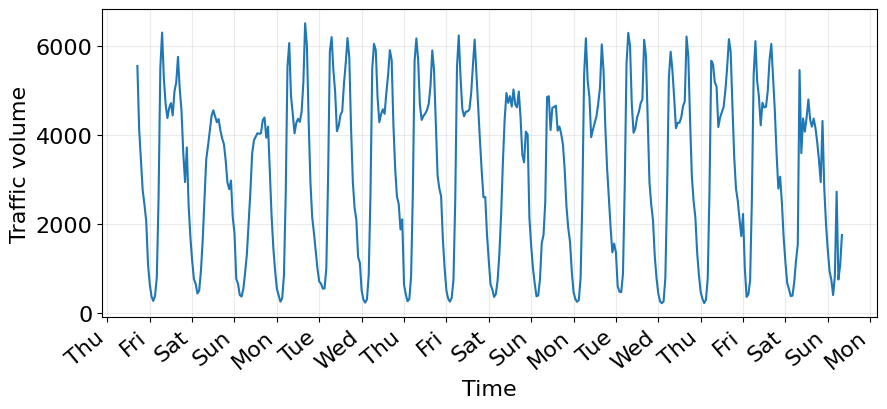

In [24]:
n_first = 400
# n_first = -1
plot_time_series(df_traffic[:n_first]["date_time"], 
                  df_traffic[:n_first]["traffic_volume"], ylabel="Traffic volume",
                  use_weekday_locator=True, use_year_locator=False)

In the above plot, we have daily seasonality. Let us see the other
seasonality in the time series.

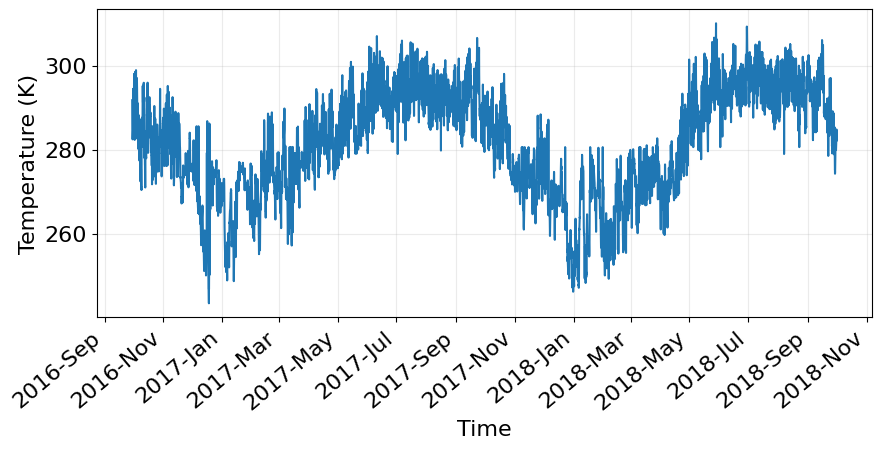

In [25]:

plot_time_series(df_traffic["date_time"], df_traffic["temp"], use_year_locator=True, 
                  ylabel="Temperature (K)")

The above plot shows a yearly seasonality of temperature feature. For the same
feature (temperature), we also have daily seasonality

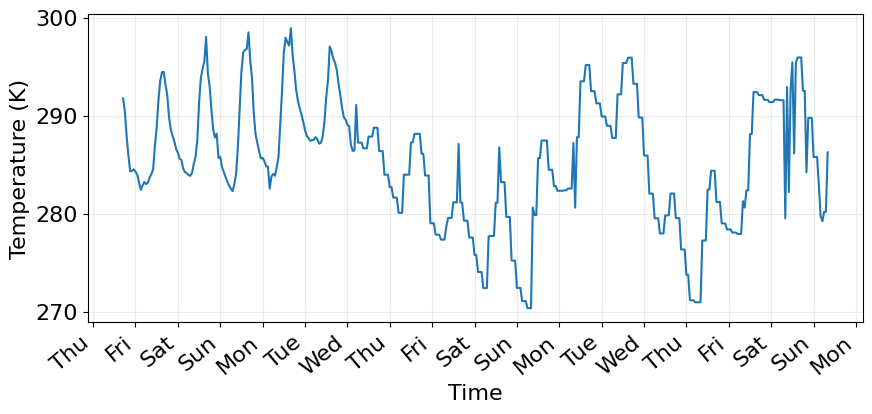

In [26]:
n_first = 400
plot_time_series(df_traffic[:n_first]["date_time"], df_traffic[:n_first]["temp"],
                  use_weekday_locator=True, ylabel="Temperature (K)")

### Feature engineering and data splitting

In [27]:
df_traffic.describe()

,date_time,temp,rain_1h,snow_1h,clouds_all,traffic_volume
count,17551,17551.000000,17551.000000,17551.0,17551.000000,17551.000000
mean,2017-09-30 08:00:00,281.416203,0.025523,0.0,42.034129,3321.484588
min,2016-09-29 17:00:00,243.390000,0.000000,0.0,0.000000,113.000000
25%,2017-03-31 12:30:00,272.220000,0.000000,0.0,1.000000,1298.000000
50%,2017-09-30 08:00:00,282.410000,0.000000,0.0,40.000000,3518.000000
75%,2018-04-01 03:30:00,291.890000,0.000000,0.0,90.000000,4943.000000
max,2018-09-30 23:00:00,310.070000,10.600000,0.0,100.000000,7280.000000
std,NaN,12.688262,0.259794,0.0,39.065960,1969.223949


- `rain_1h` is mostly 0 throughout the dataset, as its third quartile is still 
  at 0.  Since at least 75% of the values for `rain_1h` are 0, it is unlikely  
  that it is a strong predictor of traffic volume. Thus, this feature will be  
  removed
- `snow_1h` is 0 through the enitre dataset. Thus, this not predictive
   of the variation in traffic volume over time. This feature will be also be  
   removed from the dataset


In [28]:
cols_to_drop = ["rain_1h", "snow_1h"]
df_traffic_selected = df_traffic.drop(cols_to_drop, axis=1)
df_traffic_selected

,date_time,temp,clouds_all,traffic_volume
0,2016-09-29 17:00:00,291.75,0,5551.0
1,2016-09-29 18:00:00,290.36,0,4132.0
2,2016-09-29 19:00:00,287.86,0,3435.0
3,2016-09-29 20:00:00,285.91,0,2765.0
4,2016-09-29 21:00:00,284.31,0,2443.0
...,...,...,...,...
17546,2018-09-30 19:00:00,283.45,75,3543.0
17547,2018-09-30 20:00:00,282.76,90,2781.0
17548,2018-09-30 21:00:00,282.73,90,2159.0
17549,2018-09-30 22:00:00,282.09,90,1450.0


In our deep learning model, the `date_time` feature is not useful in this   
original format (string format). Now we have to encoding this feature  
to be useful for deep learning model 

We will encode the `date_time` into a categorical data for hourly.  
We can use integers 0 to 23. But this will cause a problem in our deep learning model.  
such as the model is hard to optimze (convexity of the loss function).  
The best way to encode this hourly datetime is to use the value between 0 and 1.   
This can be done by tranforming into circular categorical data where for   
each hourly data, we assign a vector on a circle.

In [38]:
temp = df_traffic_selected["date_time"].map(datetime.datetime.timestamp).values
temp[0], temp[1]

(1475139600.0, 1475143200.0)

In [39]:
temp[0] + 3600

1475143200.0

In [11]:
timestamp_sec = df_traffic_selected["date_time"]\
  .map(datetime.datetime.timestamp)
timestamp_sec

0        1.475140e+09
1        1.475143e+09
2        1.475147e+09
3        1.475150e+09
4        1.475154e+09
             ...     
17546    1.538305e+09
17547    1.538309e+09
17548    1.538312e+09
17549    1.538316e+09
17550    1.538320e+09
Name: date_time, Length: 17551, dtype: float64

In [12]:
day_in_sec = 24 * 60 * 60
df_traffic_selected["day_sin"] = (np.sin(timestamp_sec * 2*np.pi/day_in_sec)).values
df_traffic_selected["day_cos"] = (np.cos(timestamp_sec * 2*np.pi/day_in_sec)).values
df_traffic_selected.head()

,date_time,temp,clouds_all,traffic_volume,day_sin,day_cos
0,2016-09-29 17:00:00,291.75,0,5551.0,7.071068e-01,-0.707107
1,2016-09-29 18:00:00,290.36,0,4132.0,5.000000e-01,-0.866025
2,2016-09-29 19:00:00,287.86,0,3435.0,2.588190e-01,-0.965926
3,2016-09-29 20:00:00,285.91,0,2765.0,1.485292e-12,-1.000000
4,2016-09-29 21:00:00,284.31,0,2443.0,-2.588190e-01,-0.965926


Visualize `day_sin` and `day_cos`

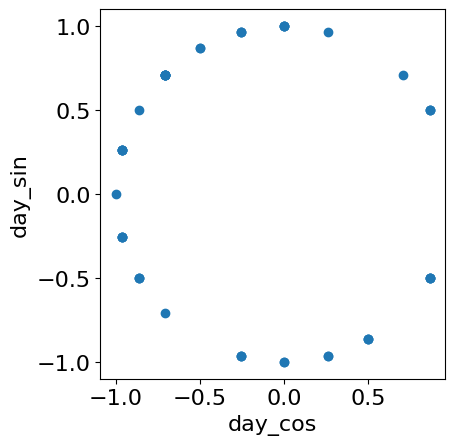

In [13]:
n_sample = 50   # randomly sample from the df_traffic_selected

fig, ax = plt.subplots()

sampled_data = df_traffic_selected.sample(n_sample)
ax.plot(sampled_data["day_cos"], sampled_data["day_sin"], linestyle="none",
        marker="o")

ax.set_aspect("equal")
ax.set_xlabel("day_cos")
ax.set_ylabel("day_sin")
plt.show(fig)

We have finished doing feature engineering. Now we move to the next step  
data splitting. We split the data into three sets: train, validation,    
and test set

In [14]:
n_data = len(df_traffic_selected)

# We drop "date_time" column because we never use it
# But for week-14, we need this column for plotting, so do not drop it
# df_traffic_selected_drop_date_time = df_traffic_selected.drop(["date_time"], axis=1)

# Split 70:20:10 (train:validation:set)
idx_train = int(n_data * 0.7)
idx_test = int(n_data * 0.9)
# train_df = df_traffic_selected_drop_date_time[:idx_train].copy()
# val_df = df_traffic_selected_drop_date_time[idx_train:idx_test].copy()
# test_df = df_traffic_selected_drop_date_time[idx_test:].copy()

train_df = df_traffic_selected[:idx_train].copy()
val_df = df_traffic_selected[idx_train:idx_test].copy()
test_df = df_traffic_selected[idx_test:].copy()


print(f"len(train, val, test): {len(train_df), len(val_df), len(test_df)}")

len(train, val, test): (12285, 3510, 1756)


To improve the performance of training deep learning model, we scale the data
between 0 and 1

In [16]:
train_df

,date_time,temp,clouds_all,traffic_volume,day_sin,day_cos
0,2016-09-29 17:00:00,291.75,0,5551.0,7.071068e-01,-0.707107
1,2016-09-29 18:00:00,290.36,0,4132.0,5.000000e-01,-0.866025
2,2016-09-29 19:00:00,287.86,0,3435.0,2.588190e-01,-0.965926
3,2016-09-29 20:00:00,285.91,0,2765.0,1.485292e-12,-1.000000
4,2016-09-29 21:00:00,284.31,0,2443.0,-2.588190e-01,-0.965926
...,...,...,...,...,...,...
12280,2018-02-23 09:00:00,270.28,90,4413.0,2.588190e-01,0.965926
12281,2018-02-23 10:00:00,270.22,75,4140.0,5.000000e-01,0.866025
12282,2018-02-23 11:00:00,271.15,90,4183.0,7.071068e-01,0.707107
12283,2018-02-23 12:00:00,271.35,75,4732.0,8.660254e-01,0.500000


In [17]:
column_for_scaling = ["temp", "clouds_all", "traffic_volume", "day_sin", "day_cos"]

# Define a scaler object
scaler_obj = MinMaxScaler()
scaler_obj.fit(train_df[column_for_scaling])

train_scale_df = train_df.copy()
val_scale_df = val_df.copy()
test_scale_df = test_df.copy()

train_scale_df[column_for_scaling] = scaler_obj.transform(train_scale_df[column_for_scaling])
val_scale_df[column_for_scaling] = scaler_obj.transform(val_scale_df[column_for_scaling])
test_scale_df[column_for_scaling] = scaler_obj.transform(test_scale_df[column_for_scaling])

display(train_scale_df.head())
display(val_scale_df.head())
display(test_scale_df.head())

,date_time,temp,clouds_all,traffic_volume,day_sin,day_cos
0,2016-09-29 17:00:00,0.760019,0.0,0.758755,0.853553,0.146447
1,2016-09-29 18:00:00,0.738174,0.0,0.560765,0.750000,0.066987
2,2016-09-29 19:00:00,0.698884,0.0,0.463513,0.629410,0.017037
3,2016-09-29 20:00:00,0.668238,0.0,0.370029,0.500000,0.000000
4,2016-09-29 21:00:00,0.643093,0.0,0.325101,0.370590,0.017037


,date_time,temp,clouds_all,traffic_volume,day_sin,day_cos
12285,2018-02-23 14:00:00,0.457646,0.01,0.700153,1.000000,0.500000
12286,2018-02-23 15:00:00,0.460946,0.20,0.769918,0.982963,0.370590
12287,2018-02-23 16:00:00,0.459375,0.05,0.872750,0.933013,0.250000
12288,2018-02-23 17:00:00,0.456388,0.20,0.776894,0.853553,0.146447
12289,2018-02-23 18:00:00,0.440830,0.05,0.664574,0.750000,0.066987


,date_time,temp,clouds_all,traffic_volume,day_sin,day_cos
15795,2018-07-19 20:00:00,0.767405,0.9,0.401563,0.500000,0.000000
15796,2018-07-19 21:00:00,0.756876,0.9,0.348821,0.370590,0.017037
15797,2018-07-19 22:00:00,0.754833,0.9,0.302637,0.250000,0.066987
15798,2018-07-19 23:00:00,0.754833,0.9,0.187108,0.146447,0.146447
15799,2018-07-20 00:00:00,0.756247,0.9,0.080926,0.066987,0.250000


Save the dataset (train, val, test) into CSV files

In [18]:
train_scale_df.to_csv("./datasets/week-13/train_scale.csv", index=False)
val_scale_df.to_csv("./datasets/week-13/val_scale.csv", index=False)
test_scale_df.to_csv("./datasets/week-13/test_scale.csv", index=False)

## 12.4 Next steps

In the next week, we will explore the baseline model, linear models,   
and deep neural network models using the data that have been prepared.